20 minute talk, 
15 minutes yapping, 5 minutes questions 

Begin: 
-Give some history.. Talk about NCAR's contribution.. Stovepiped non-interactive
- Py-ART, data model driven design
- A history of the ingests and how one by one ingests have been added.
- Enter wradlib, Use of wradlib code as a low level optional dependancy.. Contrast wradlib and Py-art, Where is the magic? 
- Py-art use inside of DoE, use in radar processing
- Py-ART use outside of DoE, Teaching (Steve), operations (Anderson)
- Py-ART as a dependancy, ART-View.. 
- What is the future, grid data model. 



In [2]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import pyart
from netCDF4 import num2date
%matplotlib inline

#Radar tools and data for LES project




- Scott Collis, Argonne National Laboratory
- Jonathan Helmus, Argonne National Laboratory

<div>
    <img class="logo" src="./python-logo.png" height="100" width="250" align="left"/>
    <img class="logo" src="./arm_logo.png" height="100" width="250" align="right"/>
</div>
<img class="logo" src="./argonne_logo.png" height="100" width="250" align='center'/>



#The Challenge

- The ARM Radars have been in a constant phase of development and have never reached a stable baseline. 

- The state of retrieval science is also evolving. And stakeholders have different desires from the data.

- We are also learning as we go

- Effectively we are building the tracks before the train, and the LASSO is a key example of this as we not piviot to fulfill the needs of this vital stakeholder. Five years ago when I started the idea of routine LES runs was not on the (ahem) radar.

<img src='./valley.png' width = 80%>

#The Agile Solution

- VAPS (NetCDF files, CMAC, MMCG, QPE, CONVV, SACRCORR) are an end product of a lot of moving parts. We have made these files available before but not the working components. 

- To this end we began, three years ago, assembling our code into an open source, data model driven architecture. Three years ago the Python-ARM Radar Toolkit was released. We now have 100's of users and 13 contributors. 

#Py-ART Can..
##Read

In [3]:
radar = pyart.io.read('/data/235545.mdv')
print(radar.fields.keys())

['differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'specific_differential_phase', 'velocity']


##Plot

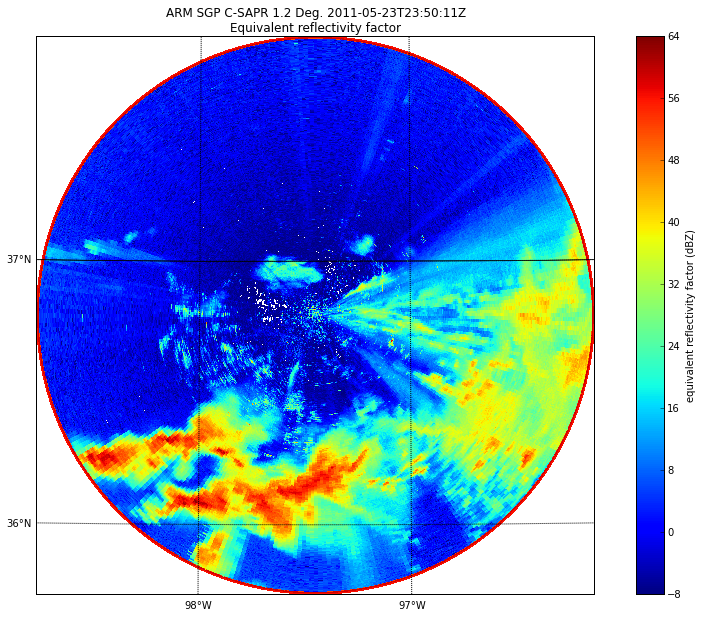

In [4]:
fig = plt.figure(figsize = [15,10])
my_d = pyart.graph.RadarMapDisplay(radar)
my_d.plot_ppi_map('reflectivity', 1, vmin =-8, vmax = 64)

#Do simple edits

In [5]:
i_end = 975
radar.range['data'] = radar.range['data'][0:i_end]
for key in radar.fields.keys():
    radar.fields[key]['data'] = radar.fields[key]['data'][:, 0:i_end]
radar.ngates = i_end


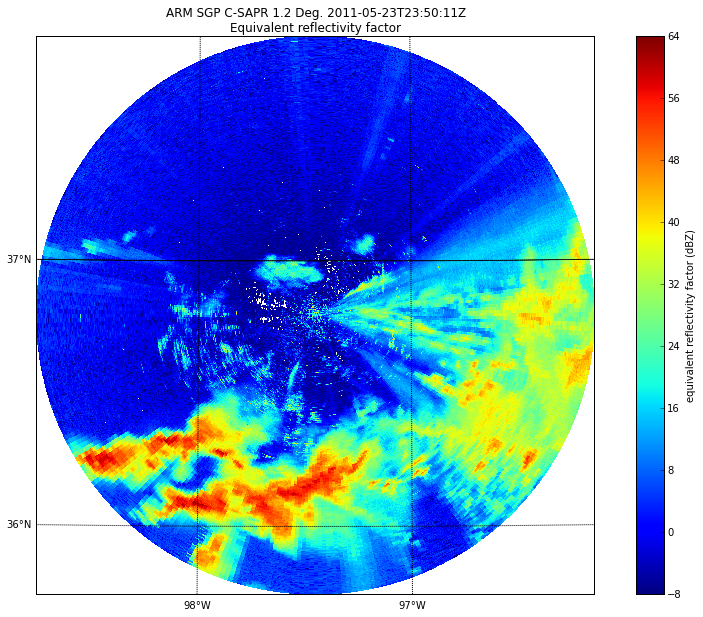

In [6]:
fig = plt.figure(figsize = [15,10])
my_d = pyart.graph.RadarMapDisplay(radar)
my_d.plot_ppi_map('reflectivity', 1, vmin =-8, vmax = 64)

#Provide some insight

In [7]:
good = np.where(radar.fields['normalized_coherent_power']['data'].flatten() > .5)[0] 
H, xedges, yedges = np.histogram2d(my_d.z.flatten()[good]/1000.0,
    radar.fields['reflectivity']['data'].flatten()[good],
     bins=(62, 60), range=([0,17], [-10,64]))

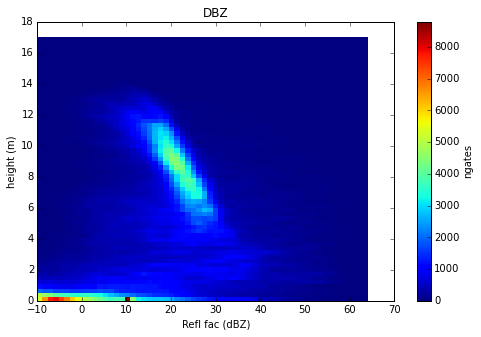

In [8]:
fig = plt.figure(figsize=[8,5])
plt.pcolormesh(yedges, xedges, H)
plt.xlabel('Refl fac (dBZ)'); plt.ylabel('height (m)');cb=plt.colorbar()
cb.set_label('ngates')
plt.title('DBZ')

#Grid to a Cartesian Grid

In [9]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(36, 701, 701),
        grid_limits=((0, 17000.0),(-90000, 90000), (-100000, 100000)),

        gridding_algo="map_gates_to_grid",
        weighting_function='CRESSMAN')

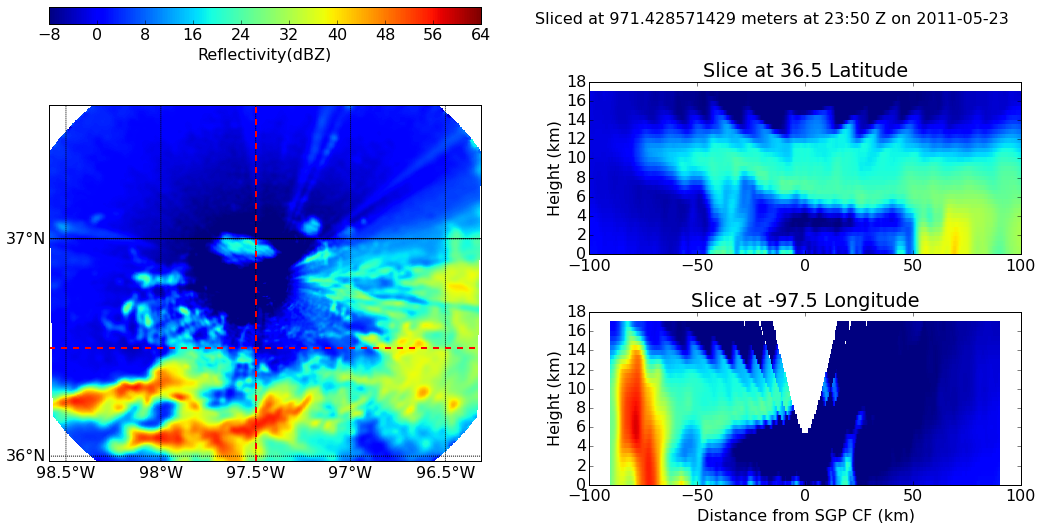

In [10]:
display = pyart.graph.GridMapDisplay(grids)

# create the figure
font = {'size': 16}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[15, 8])

# panel sizes
map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .30]
y_cut_panel_axes = [0.55, 0.50, .4, .30]
colorbar_panel_axes = [0.05, 0.90, .4, .03]

# parameters
level = 2
vmin = -8
vmax = 64
lat = 36.5
lon = -97.5

# panel 1, basemap, radar reflectivity and NARR overlay
ax1 = fig.add_axes(map_panel_axes)
display.plot_basemap(lon_lines = np.arange(-104, -93, 0.5) )
display.plot_grid('reflectivity', level=level, vmin=vmin, vmax=vmax)
display.plot_crosshairs(lon=lon, lat=lat)

# plot the reanalysis on the basemap
# colorbar
cbax = fig.add_axes(colorbar_panel_axes)
display.plot_colorbar(cax=cbax)

# panel 2, longitude slice.
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)
ax2.set_xlabel('Distance from SGP CF (km)')

# panel 3, latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, vmin=vmin, vmax=vmax)

# add a title
slc_height = grids.axes['z_disp']['data'][level]
dts = num2date(grids.axes['time']['data'], grids.axes['time']['units'])
datestr = dts[0].strftime('%H:%M Z on %Y-%m-%d')
title = 'Sliced at ' + str(slc_height) + ' meters at ' + datestr
fig.text(0.5, 0.9, title)




#Retrieve

<img src='qpe.png'>


#Write to Cf-Complaint grids

In [11]:
pyart.io.write_grid('/data/my_awesome_grid.nc', grids)

In [12]:
!ncdump -h /data/my_awesome_grid.nc

netcdf my_awesome_grid {
dimensions:
	time = UNLIMITED ; // (1 currently)
	nz = 36 ;
	ny = 701 ;
	nx = 701 ;
variables:
	double time(time) ;
		time:long_name = "Time in seconds since volume start" ;
		time:units = "seconds since 2011-05-23T23:50:11Z" ;
		time:calendar = "gregorian" ;
		time:standard_name = "time" ;
	double time_end(time) ;
		time_end:long_name = "Time in seconds of volume end" ;
		time_end:units = "seconds since 2011-05-23T23:50:11Z" ;
		time_end:calendar = "gregorian" ;
		time_end:standard_name = "time" ;
	double time_start(time) ;
		time_start:long_name = "Time in seconds of volume start" ;
		time_start:units = "seconds since 2011-05-23T23:50:11Z" ;
		time_start:calendar = "gregorian" ;
		time_start:standard_name = "time" ;
	double x_disp(nx) ;
		x_disp:long_name = "X-coordinate in Cartesian system" ;
		x_disp:units = "m" ;
		x_disp:axis = "X" ;
	double y_disp(ny) ;
		y_disp:long_name = "Y-coordinate in Cartesian system" ;
		y_disp:units = "m" ;
		y_disp:axis = "Y" ;

#Discussion points

- What retrevals and products will be useful? VADs to get shear profiles? Some looking at clear air returns, bugs etc.. 

- Is the LASSO team looking for assistance in managing and analyzing grid data? We are modifying the grid model for Py-ART and working with folks from NCAR on a general model for Python. 

- Lets define the domain! Let us know the domain(s) for LASSO and we can develop a map from radar space to this domain. 